In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/WTI原油期货价格拟合残差_WTI连1-连4.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['WTI原油期货价格拟合残差/WTI连1-连4月差'].last_valid_index()

target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=60, freq='B')
sheet = sheet.reindex(sheet.index.union(target_days))
sheet = sheet[sheet.index <= target_days[-1]]

sheet.tail()

,WTI原油期货价格拟合残差/WTI连1-连4月差,EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年,全球石油去库幅度/EIA月报调整/3MMA超季节性/3年
2025-10-17,NaN,NaN,NaN
2025-10-20,NaN,NaN,NaN
2025-10-21,NaN,NaN,NaN
2025-10-22,NaN,NaN,NaN
2025-10-23,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['WTI原油期货价格拟合残差/WTI连1-连4月差', 'EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年',
       '全球石油去库幅度/EIA月报调整/3MMA超季节性/3年'],
      dtype='object')

In [8]:
################################# 处理缺失值 #################################
fill_methods = {
'EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年':'interpolate',
'全球石油去库幅度/EIA月报调整/3MMA超季节性/3年':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, 'WTI原油期货价格拟合残差/WTI连1-连4月差'] = sheet.loc[:last_day, 'WTI原油期货价格拟合残差/WTI连1-连4月差'].interpolate(method='linear')

#################################  因子处理  #################################


#sheet['美国PADD2原油库存（路透）(预测/线性外推)_退后10天'] = sheet['美国PADD2原油库存（路透）(预测/线性外推)'].shift(-10)


#sheet['美国PADD2原油库存（路透）(预测/线性外推)_退后10天_逆序'] = reverse_column(sheet, '美国PADD2原油库存（路透）(预测/线性外推)_退后10天')



################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2021-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['WTI原油期货价格拟合残差/WTI连1-连4月差'].notna())
]

################################# 数据 读取-处理 结束 #################################

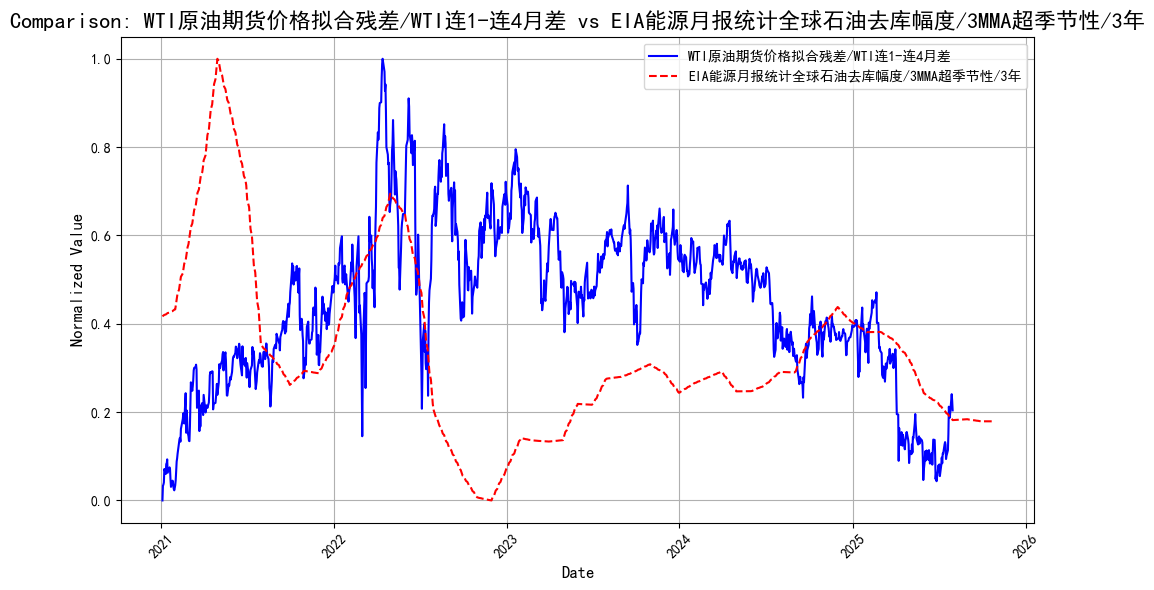

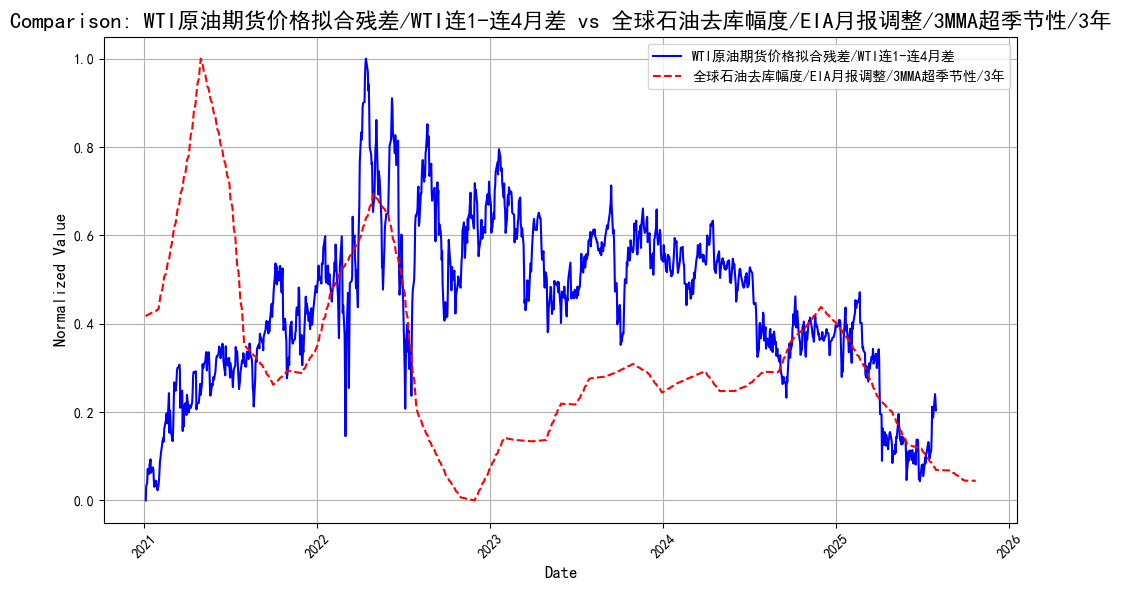

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='WTI原油期货价格拟合残差/WTI连1-连4月差', 
    compare_cols=[
        'EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年',
        '全球石油去库幅度/EIA月报调整/3MMA超季节性/3年'
        ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 21
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    'EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年',
    '全球石油去库幅度/EIA月报调整/3MMA超季节性/3年'
]

predict_column = 'WTI原油期货价格拟合残差/WTI连1-连4月差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [28]:

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 85)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 默认学习率
    'max_depth': 12,  # 默认树深度
    'min_child_weight': 1,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0.5,  # 默认L1正则化
    'reg_lambda': 1.5,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
    'booster': 'gblinear'  # 使用线性模型作为基学习器
}


num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix


[0]	eval-rmse:14.42954	train-rmse:7.51529
[500]	eval-rmse:15.37423	train-rmse:7.22542


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:05:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[999]	eval-rmse:15.37116	train-rmse:7.22468
训练集 MSE (DMatrix): 61.1394, 训练集 R² (DMatrix): 0.0563
测试集 MSE (DMatrix): 236.2724, 测试集 R² (DMatrix): -35.7339


In [29]:

################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all


[0]	train-rmse:7.66314
[500]	train-rmse:7.42995


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:05:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[999]	train-rmse:7.42902
全部数据 MSE: 64.3339, 全部数据 R²: 0.0433


In [30]:
'''
################################# TabPFN 模型 训练 测试 预测 #################################

# 初始化回归器
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred


SyntaxError: incomplete input (2697010416.py, line 1)

In [31]:
'''
################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor()
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all
'''

'\n################################# TabPFN 模型 训练 测试 预测 所有数据 #################################\n# 合并所有数据\nX_all = pd.concat([X_train, X_test]).reset_index(drop=True)\ny_all = pd.concat([y_train, y_test]).reset_index(drop=True)\n\n# 初始化回归器\nregressor_all = TabPFNRegressor()\nregressor_all.fit(X_all, y_all)\n\n# 预测所有数据和未来数据\ny_all_pred = regressor_all.predict(X_all)\ny_future_pred_all = regressor_all.predict(X_future)\n\n# 评估模型\nall_mse = mean_squared_error(y_all, y_all_pred)\nall_r2 = r2_score(y_all, y_all_pred)\n\nprint(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")\n\n# 存储全部数据的预测结果\nall_data = pd.concat([train_data, test_data]).reset_index(drop=True)\nall_data.loc[:, \'预测值_全量\'] = y_all_pred\nfuture_data.loc[:, \'预测值_全量\'] = y_future_pred_all\n'

In [32]:
'''
# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=regressor_all,
    X=X_all,
    y=y_all,
    n_features_to_select=5,  # How many features to select
    feature_names=X_all.columns,
)

# Print selected features
selected_features = [
    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")
'''

'\n# Feature selection\nsfs = interpretability.feature_selection.feature_selection(\n    estimator=regressor_all,\n    X=X_all,\n    y=y_all,\n    n_features_to_select=5,  # How many features to select\n    feature_names=X_all.columns,\n)\n\n# Print selected features\nselected_features = [\n    X_all.columns[i] for i in range(len(X_all.columns)) if sfs.get_support()[i]\n]\nprint("\nSelected features:")\nfor feature in selected_features:\n    print(f"- {feature}")\n'

In [33]:
'''
# Get a TabPFNExplainer
n_model_evals = 500
x_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组
explainer = tabpfn_shapiq.get_tabpfn_explainer(
    model=regressor_all,
    data=X_all,
    labels=X_all, 
    index="SV",  # SV: Shapley Value (like in shap)
    verbose=True,  # show a progress bar during explanation
)

# Get shap values
print("计算SHAP值...")
shapley_values = explainer.explain(x=x_explain, budget=n_model_evals)

# plot the force plot
shapley_values.plot_force(feature_names=X_all.columns)
'''

'\n# Get a TabPFNExplainer\nn_model_evals = 500\nx_explain = X_all.iloc[0].to_numpy() # 转换为numpy数组\nexplainer = tabpfn_shapiq.get_tabpfn_explainer(\n    model=regressor_all,\n    data=X_all,\n    labels=X_all, \n    index="SV",  # SV: Shapley Value (like in shap)\n    verbose=True,  # show a progress bar during explanation\n)\n\n# Get shap values\nprint("计算SHAP值...")\nshapley_values = explainer.explain(x=x_explain, budget=n_model_evals)\n\n# plot the force plot\nshapley_values.plot_force(feature_names=X_all.columns)\n'

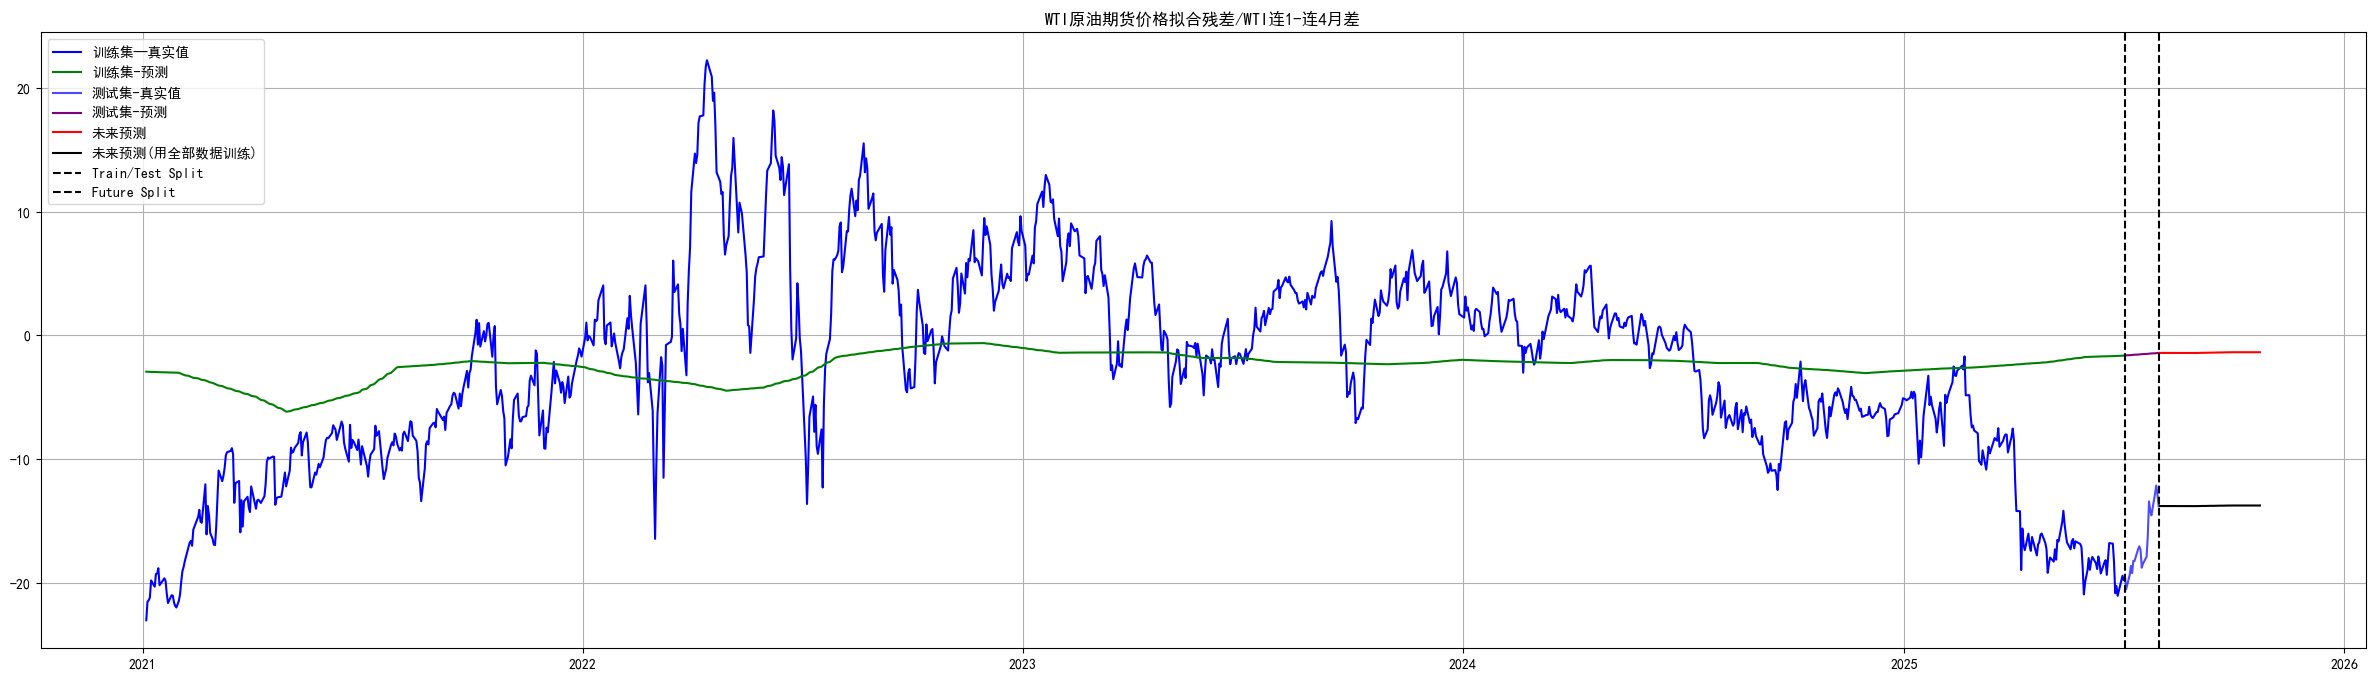

In [34]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
#plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
#plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('WTI原油期货价格拟合残差/WTI连1-连4月差')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
#merged_df_daily.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_日度数据.xlsx', index=False,float_format='%.3f')

merged_df_daily

,Date,真实值,预测值
718,2025/10/23,NaN,-13.761652
717,2025/10/22,NaN,-13.761652
716,2025/10/21,NaN,-13.761652
715,2025/10/20,NaN,-13.761652
714,2025/10/17,NaN,-13.761652
...,...,...,...
4,2023/01/09,6.4592,NaN
3,2023/01/06,4.9309,NaN
2,2023/01/05,4.9583,NaN
1,2023/01/04,4.4209,NaN


In [36]:
# 假设 merged_df_daily 已经在内存中
merged_df_daily_sum = merged_df_daily.copy()

# 确保日期是 datetime 类型
merged_df_daily_sum['Date'] = pd.to_datetime(merged_df_daily_sum['Date'])

# 真实值保持原样（不用修改）
# 计算所有有值预测值的全局均值
global_mean_pred = merged_df_daily['预测值'].mean()

# 用全局均值替换预测值列（保留原始缺失的 NaN 不填）
merged_df_daily_sum['预测值'] = merged_df_daily['预测值'].apply(
    lambda x: global_mean_pred if pd.notna(x) else x
)

# 格式化日期为字符串形式
merged_df_daily_sum['Date'] = merged_df_daily_sum['Date'].dt.strftime('%Y/%m/%d')

# 保存到 Excel
merged_df_daily_sum.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_日度数据_预测值全局均值填充.xlsx', index=False, float_format='%.3f')

# 可选：查看头部数据
merged_df_daily_sum.head()


,Date,真实值,预测值
718,2025/10/23,NaN,-13.786627
717,2025/10/22,NaN,-13.786627
716,2025/10/21,NaN,-13.786627
715,2025/10/20,NaN,-13.786627
714,2025/10/17,NaN,-13.786627


In [37]:
'''
# 假设 merged_df_daily 已经在内存中
merged_df_daily_sum = merged_df_daily.copy()

# 转换日期格式
merged_df_daily_sum['Date'] = pd.to_datetime(merged_df_daily_sum['Date'])

# 添加月份标签
merged_df_daily_sum['Month'] = merged_df_daily_sum['Date'].dt.to_period('M')

# 计算月均值并替换对应列
monthly_means = merged_df_daily_sum.groupby('Month')[['真实值', '预测值']].transform('mean')
merged_df_daily_sum[['真实值', '预测值']] = monthly_means

# 删除 Month 辅助列
merged_df_daily_sum.drop(columns=['Month'], inplace=True)

# 转换日期格式为指定格式
merged_df_daily_sum['Date'] = merged_df_daily_sum['Date'].dt.strftime('%Y/%m/%d')

# 如果需要保存文件
merged_df_daily_sum.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_日度数据_月均值填充.xlsx', index=False, float_format='%.3f')
merged_df_daily_sum.head()
'''

"\n# 假设 merged_df_daily 已经在内存中\nmerged_df_daily_sum = merged_df_daily.copy()\n\n# 转换日期格式\nmerged_df_daily_sum['Date'] = pd.to_datetime(merged_df_daily_sum['Date'])\n\n# 添加月份标签\nmerged_df_daily_sum['Month'] = merged_df_daily_sum['Date'].dt.to_period('M')\n\n# 计算月均值并替换对应列\nmonthly_means = merged_df_daily_sum.groupby('Month')[['真实值', '预测值']].transform('mean')\nmerged_df_daily_sum[['真实值', '预测值']] = monthly_means\n\n# 删除 Month 辅助列\nmerged_df_daily_sum.drop(columns=['Month'], inplace=True)\n\n# 转换日期格式为指定格式\nmerged_df_daily_sum['Date'] = merged_df_daily_sum['Date'].dt.strftime('%Y/%m/%d')\n\n# 如果需要保存文件\nmerged_df_daily_sum.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_日度数据_月均值填充.xlsx', index=False, float_format='%.3f')\nmerged_df_daily_sum.head()\n"

In [38]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    #'预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
# 只保留2024年10月1日之后的预测值
merged_df_monthly.loc[merged_df_monthly.index < pd.Timestamp('2024-10-01'), '预测值'] = None

merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
#merged_df_monthly.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_月度数据.xlsx', index=False, float_format='%.3f')
merged_df_monthly.head()

,Date,真实值,预测值
21,2025/10/31,NaN,-13.761652
20,2025/09/30,NaN,-13.784863
19,2025/08/31,NaN,-13.807693
18,2025/07/31,-16.945039,-1.531548
17,2025/06/30,-18.753925,-1.700358


In [39]:
# 复制原始月度数据
merged_df_monthly_sum = merged_df_monthly.copy()

# 将日期列转为 datetime 类型（如原来是字符串）
merged_df_monthly_sum['Date'] = pd.to_datetime(merged_df_monthly_sum['Date'])

# 按时间降序排列，确保最近三个月正确识别
merged_df_monthly_sum = merged_df_monthly_sum.sort_values('Date', ascending=False)

# 获取最近三个"有预测值"的月份
recent_months = merged_df_monthly_sum[merged_df_monthly_sum['预测值'].notna()]['Date'].dt.to_period('M').unique()[:3]

# 构造布尔掩码：找出属于这三个月的行
recent_3_months_mask = merged_df_monthly_sum['Date'].dt.to_period('M').isin(recent_months)

# 计算这三个月的预测值的均值
recent_3_months_mean = merged_df_monthly_sum.loc[recent_3_months_mask, '预测值'].mean()

# 替换这三个月的预测值为均值（只影响这三个月，其他保持不变）
merged_df_monthly_sum.loc[recent_3_months_mask, '预测值'] = recent_3_months_mean

# 恢复日期为字符串格式
merged_df_monthly_sum['Date'] = merged_df_monthly_sum['Date'].dt.strftime('%Y/%m/%d')

# 保存结果（可选）
merged_df_monthly_sum.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_月度数据_后三月预测均值填充.xlsx', index=False, float_format='%.3f')

# 可选查看
merged_df_monthly_sum.head()


,Date,真实值,预测值
21,2025/10/31,NaN,-13.784737
20,2025/09/30,NaN,-13.784737
19,2025/08/31,NaN,-13.784737
18,2025/07/31,-16.945039,-1.531548
17,2025/06/30,-18.753925,-1.700358


In [40]:
'''
# 复制原始月度数据
merged_df_monthly_sum = merged_df_monthly.copy()

# 确保日期列是 datetime 类型
merged_df_monthly_sum['Date'] = pd.to_datetime(merged_df_monthly_sum['Date'])

# 添加季度标签
merged_df_monthly_sum['Quarter'] = merged_df_monthly_sum['Date'].dt.to_period('Q')

# 分组计算季度均值（不改变 NaN 的位置）
quarterly_group = merged_df_monthly_sum.groupby('Quarter')
merged_df_monthly_sum['真实值_季度均'] = quarterly_group['真实值'].transform('mean')
merged_df_monthly_sum['预测值_季度均'] = quarterly_group['预测值'].transform('mean')

# 仅替换原本非空的值，其它保持为 NaN
merged_df_monthly_sum['真实值'] = merged_df_monthly_sum['真实值'].where(
    merged_df_monthly_sum['真实值'].isna(), merged_df_monthly_sum['真实值_季度均']
)
merged_df_monthly_sum['预测值'] = merged_df_monthly_sum['预测值'].where(
    merged_df_monthly_sum['预测值'].isna(), merged_df_monthly_sum['预测值_季度均']
)

# 删除辅助列
merged_df_monthly_sum.drop(columns=['Quarter', '真实值_季度均', '预测值_季度均'], inplace=True)

# 格式化日期列为字符串
merged_df_monthly_sum['Date'] = merged_df_monthly_sum['Date'].dt.strftime('%Y/%m/%d')

# 保存结果
merged_df_monthly_sum.to_excel('eta/wti_连1-连4月差_月度数据_均值填充.xlsx', index=False, float_format='%.3f')

# 输出最终结果（可选）
merged_df_monthly_sum.head()
'''

"\n# 复制原始月度数据\nmerged_df_monthly_sum = merged_df_monthly.copy()\n\n# 确保日期列是 datetime 类型\nmerged_df_monthly_sum['Date'] = pd.to_datetime(merged_df_monthly_sum['Date'])\n\n# 添加季度标签\nmerged_df_monthly_sum['Quarter'] = merged_df_monthly_sum['Date'].dt.to_period('Q')\n\n# 分组计算季度均值（不改变 NaN 的位置）\nquarterly_group = merged_df_monthly_sum.groupby('Quarter')\nmerged_df_monthly_sum['真实值_季度均'] = quarterly_group['真实值'].transform('mean')\nmerged_df_monthly_sum['预测值_季度均'] = quarterly_group['预测值'].transform('mean')\n\n# 仅替换原本非空的值，其它保持为 NaN\nmerged_df_monthly_sum['真实值'] = merged_df_monthly_sum['真实值'].where(\n    merged_df_monthly_sum['真实值'].isna(), merged_df_monthly_sum['真实值_季度均']\n)\nmerged_df_monthly_sum['预测值'] = merged_df_monthly_sum['预测值'].where(\n    merged_df_monthly_sum['预测值'].isna(), merged_df_monthly_sum['预测值_季度均']\n)\n\n# 删除辅助列\nmerged_df_monthly_sum.drop(columns=['Quarter', '真实值_季度均', '预测值_季度均'], inplace=True)\n\n# 格式化日期列为字符串\nmerged_df_monthly_sum['Date'] = merged_df_monthly_sum['Date'].dt.s

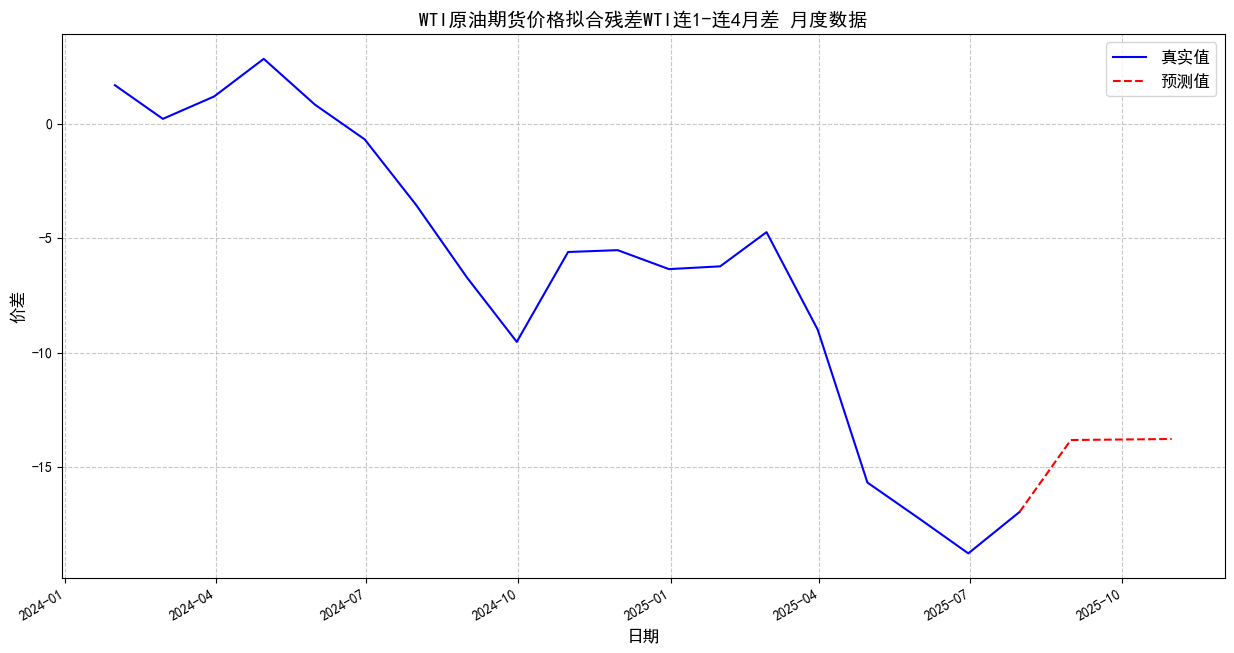

In [41]:
# 画图前先将数据按时间正序排列
plot_df = merged_df_monthly.copy()
plot_df['Date'] = pd.to_datetime(plot_df['Date'])
plot_df = plot_df.sort_values('Date')

# 获取最后一个真实值的日期
last_actual_date = plot_df[plot_df['真实值'].notna()]['Date'].max()
# 先将真实值转换为float类型再赋值给预测值
last_actual_value = plot_df.loc[plot_df['Date'] == last_actual_date, '真实值'].iloc[0].astype('float32')
plot_df.loc[plot_df['Date'] == last_actual_date, '预测值'] = last_actual_value
plot_df.loc[plot_df['Date'] < last_actual_date, '预测值'] = None

# 设置绘图参数
plt.figure(figsize=(15, 8))
plt.plot(plot_df['Date'], plot_df['真实值'], label='真实值', color='blue')
plt.plot(plot_df['Date'], plot_df['预测值'], label='预测值', color='red', linestyle='--')

# 添加标题和标签
plt.title('WTI原油期货价格拟合残差WTI连1-连4月差 月度数据', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('价差', fontsize=12)
plt.legend(fontsize=12)
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [42]:
# 转换为季度数据
merged_df_quarterly = merged_df_monthly.copy()
merged_df_quarterly['Date'] = pd.to_datetime(merged_df_quarterly['Date'])
merged_df_quarterly.set_index('Date', inplace=True)
merged_df_quarterly = merged_df_quarterly.resample('QE').mean()
merged_df_quarterly.reset_index(inplace=True)
merged_df_quarterly['Date'] = merged_df_quarterly['Date'].dt.strftime('%Y/%m/%d')
merged_df_quarterly = merged_df_quarterly.sort_values('Date', ascending=False)
#merged_df_quarterly.to_excel('eta/WTI原油期货价格拟合残差WTI连1-连4月差_季度数据.xlsx', index=False, float_format='%.2f')
merged_df_quarterly.head()

,Date,真实值,预测值
7,2025/12/31,NaN,-13.761652
6,2025/09/30,-16.945039,-9.708035
5,2025/06/30,-17.211473,-1.975851
4,2025/03/31,-6.653588,-2.633302
3,2024/12/31,-5.823489,-2.874597


In [43]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.原油季度_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI原油期货价格拟合残差/WTI连1-连4月差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily_sum, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

错误：未找到标识符 WTI原油期货价格拟合残差/WTI连1-连4月差
数据更新失败，请检查错误信息


In [ ]:
from Lcel import update_excel_data
file_path =  "eta/1.原油季度_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI原油期货价格拟合残差/WTI连1-连4月差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly_sum, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


In [ ]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'SC期货指数-Brent原油期货价格',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''